# Brain Tumor MRI Classification - Complete ML Pipeline

This notebook demonstrates the complete machine learning pipeline for brain tumor classification from MRI images.

## Dataset
- **Source**: Kaggle - Brain Tumor MRI Dataset
- **Classes**: Glioma, Meningioma, No Tumor, Pituitary
- **Structure**: Train/Test split with class subdirectories

## Pipeline Steps:
1. Data Acquisition and Exploration
2. Data Preprocessing and Feature Extraction
3. Model Creation (Transfer Learning)
4. Model Training with Optimization
5. Model Evaluation with Multiple Metrics
6. Model Testing and Prediction


In [2]:
# Import necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Add src to path
sys.path.append('./src')

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sklearn for evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Import custom modules
from preprocessing import extract_features_from_directory, prepare_data_for_training, get_class_names
from model import BrainTumorClassifier

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.20.0
GPU Available: []


## 1. Data Acquisition and Exploration

Let's first explore the dataset structure and understand the data distribution.


Classes found: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of classes: 4
Training - glioma: 1321 images
Training - meningioma: 1339 images
Training - notumor: 1595 images
Training - pituitary: 1457 images
Test - glioma: 300 images
Test - meningioma: 306 images
Test - notumor: 405 images
Test - pituitary: 300 images


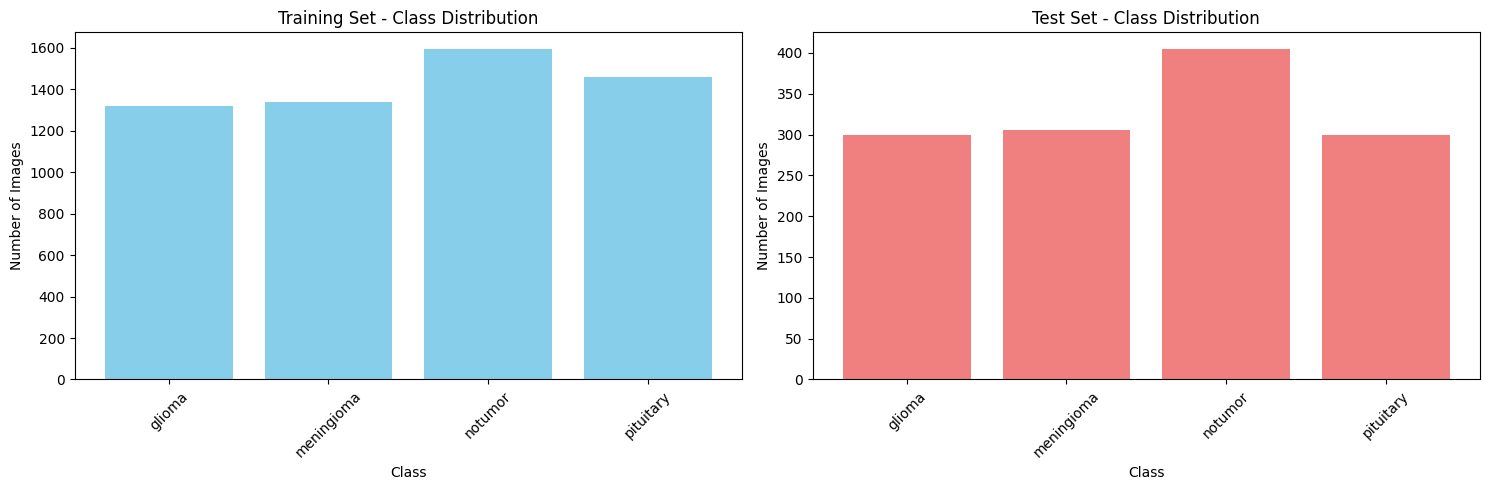


Total training images: 5712
Total test images: 1311


In [3]:
# Explore dataset structure
data_dir = './data/train'
test_dir = './data/test'

# Get class names
class_names = get_class_names(data_dir)
print(f"Classes found: {class_names}")
print(f"Number of classes: {len(class_names)}")

# Count images per class in training set
train_counts = {}
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    if os.path.exists(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        train_counts[class_name] = count
        print(f"Training - {class_name}: {count} images")

# Count images per class in test set
test_counts = {}
for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    if os.path.exists(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        test_counts[class_name] = count
        print(f"Test - {class_name}: {count} images")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set distribution
axes[0].bar(train_counts.keys(), train_counts.values(), color='skyblue')
axes[0].set_title('Training Set - Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Images')
axes[0].tick_params(axis='x', rotation=45)

# Test set distribution
axes[1].bar(test_counts.keys(), test_counts.values(), color='lightcoral')
axes[1].set_title('Test Set - Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Images')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nTotal training images: {sum(train_counts.values())}")
print(f"Total test images: {sum(test_counts.values())}")


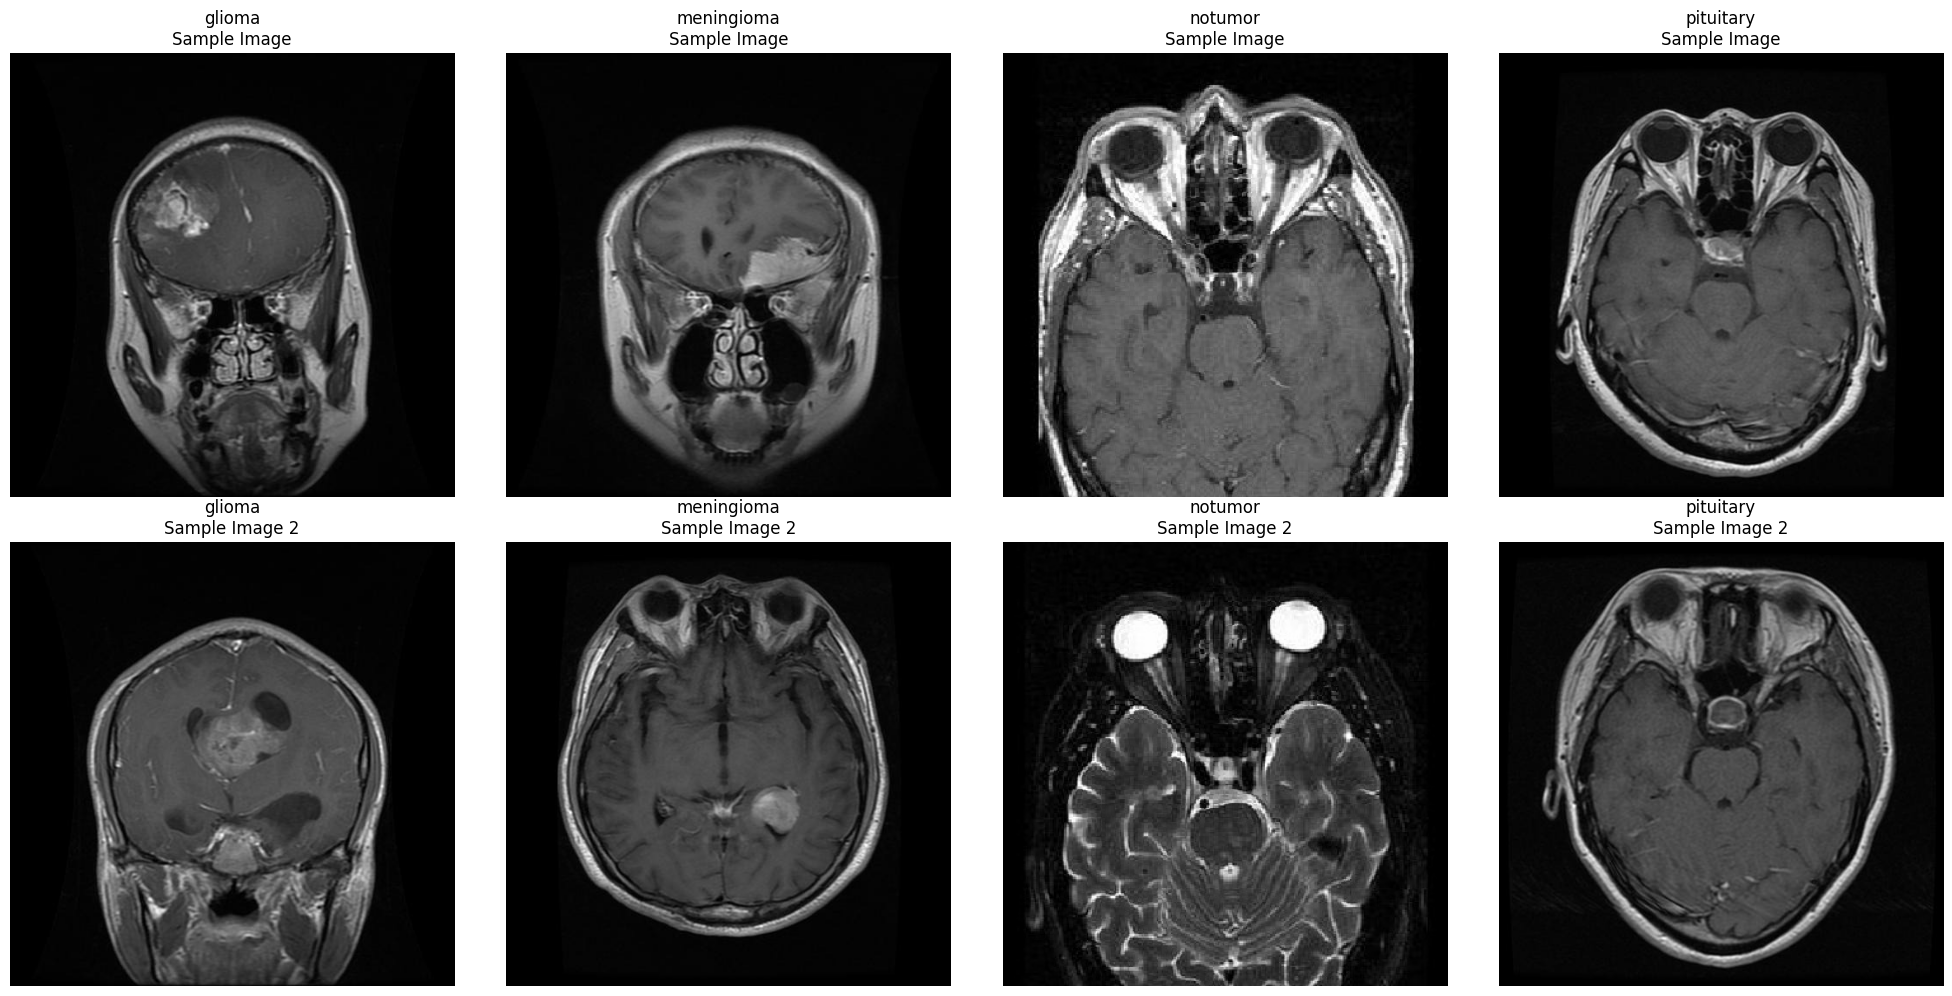

In [4]:
# Display sample images from each class
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    if os.path.exists(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if images:
            img_path = os.path.join(class_path, images[0])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(img)
            axes[idx].set_title(f'{class_name}\nSample Image')
            axes[idx].axis('off')
            axes[idx+4].imshow(cv2.cvtColor(cv2.imread(os.path.join(class_path, images[1] if len(images) > 1 else images[0])), cv2.COLOR_BGR2RGB))
            axes[idx+4].set_title(f'{class_name}\nSample Image 2')
            axes[idx+4].axis('off')

plt.tight_layout()
plt.show()


## 2. Data Preprocessing and Feature Extraction

Extract features from images and save to CSV for analysis and visualization.


In [5]:
# Extract features from training data
print("Extracting features from training data...")
train_features_df = extract_features_from_directory(data_dir, './data/processed/image_features_train.csv')

print(f"\nTraining features shape: {train_features_df.shape}")
print(f"Feature columns: {train_features_df.columns.tolist()}")
print("\nFirst few rows:")
train_features_df.head()


Extracting features from training data...
Found 4 classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Processing 1321 images from glioma...
Processing 1339 images from meningioma...
Processing 1595 images from notumor...
Processing 1457 images from pituitary...
Features saved to ../data/processed/image_features_train.csv
Total features extracted: 5712
Feature columns: ['hist_mean', 'hist_std', 'hist_median', 'hist_max', 'hist_min', 'mean_intensity', 'std_intensity', 'median_intensity', 'min_intensity', 'max_intensity', 'variance', 'gradient_mean', 'gradient_std', 'width', 'height', 'aspect_ratio', 'image_path', 'class']

Training features shape: (5712, 18)
Feature columns: ['hist_mean', 'hist_std', 'hist_median', 'hist_max', 'hist_min', 'mean_intensity', 'std_intensity', 'median_intensity', 'min_intensity', 'max_intensity', 'variance', 'gradient_mean', 'gradient_std', 'width', 'height', 'aspect_ratio', 'image_path', 'class']

First few rows:


,hist_mean,hist_std,hist_median,hist_max,hist_min,mean_intensity,std_intensity,median_intensity,min_intensity,max_intensity,variance,gradient_mean,gradient_std,width,height,aspect_ratio,image_path,class
0,196.0,938.667358,69.5,12032.0,0.0,31.331433,43.157362,4.0,0,246,1862.557921,47.246231,88.685289,224,224,1.0,../data/train\glioma\Tr-glTr_0000.jpg,glioma
1,196.0,856.571716,45.0,11283.0,0.0,37.785435,43.340809,5.0,0,242,1878.425741,45.188021,85.281782,224,224,1.0,../data/train\glioma\Tr-glTr_0001.jpg,glioma
2,196.0,829.073914,32.0,11034.0,0.0,35.977101,40.673852,7.0,0,240,1654.362219,47.078320,89.254661,224,224,1.0,../data/train\glioma\Tr-glTr_0002.jpg,glioma
3,196.0,857.342712,11.0,11212.0,0.0,24.847816,27.660327,12.0,0,239,765.093709,37.159590,71.483427,224,224,1.0,../data/train\glioma\Tr-glTr_0003.jpg,glioma
4,196.0,770.261292,16.0,11094.0,0.0,32.013473,33.277927,24.0,0,244,1107.420458,43.175947,75.853839,224,224,1.0,../data/train\glioma\Tr-glTr_0004.jpg,glioma


In [6]:
# Extract features from test data
print("Extracting features from test data...")
test_features_df = extract_features_from_directory(test_dir, './data/processed/image_features_test.csv')

print(f"\nTest features shape: {test_features_df.shape}")
print("\nFirst few rows:")
test_features_df.head()


Extracting features from test data...
Found 4 classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Processing 300 images from glioma...
Processing 306 images from meningioma...
Processing 405 images from notumor...
Processing 300 images from pituitary...
Features saved to ../data/processed/image_features_test.csv
Total features extracted: 1311
Feature columns: ['hist_mean', 'hist_std', 'hist_median', 'hist_max', 'hist_min', 'mean_intensity', 'std_intensity', 'median_intensity', 'min_intensity', 'max_intensity', 'variance', 'gradient_mean', 'gradient_std', 'width', 'height', 'aspect_ratio', 'image_path', 'class']

Test features shape: (1311, 18)

First few rows:


,hist_mean,hist_std,hist_median,hist_max,hist_min,mean_intensity,std_intensity,median_intensity,min_intensity,max_intensity,variance,gradient_mean,gradient_std,width,height,aspect_ratio,image_path,class
0,196.0,1049.424316,38.5,16107.0,0.0,30.453862,39.377121,6.0,0,245,1550.557621,43.506555,81.265234,224,224,1.0,../data/test\glioma\Te-glTr_0000.jpg,glioma
1,196.0,1078.963379,16.5,15820.0,0.0,23.451291,30.964269,3.0,0,245,958.785973,33.727731,64.054250,224,224,1.0,../data/test\glioma\Te-glTr_0001.jpg,glioma
2,196.0,1265.025635,10.0,16494.0,0.0,17.328583,25.376095,2.0,0,212,643.946222,22.951393,59.928954,224,224,1.0,../data/test\glioma\Te-glTr_0002.jpg,glioma
3,196.0,970.719788,57.5,13995.0,0.0,31.757334,44.737567,5.0,0,252,2001.449922,50.561543,88.285813,224,224,1.0,../data/test\glioma\Te-glTr_0003.jpg,glioma
4,196.0,1008.006470,22.0,14788.0,0.0,24.951431,32.547691,4.0,0,241,1059.352173,34.397313,65.742080,224,224,1.0,../data/test\glioma\Te-glTr_0004.jpg,glioma


Feature Statistics by Class:
           hist_mean                                                hist_std  \
               count   mean  std    min    25%    50%    75%    max    count   
class                                                                          
glioma        1321.0  196.0  0.0  196.0  196.0  196.0  196.0  196.0   1321.0   
meningioma    1339.0  196.0  0.0  196.0  196.0  196.0  196.0  196.0   1339.0   
notumor       1595.0  196.0  0.0  196.0  196.0  196.0  196.0  196.0   1595.0   
pituitary     1457.0  196.0  0.0  196.0  196.0  196.0  196.0  196.0   1457.0   

                        ... height        aspect_ratio                      \
                  mean  ...    75%    max        count mean  std  min  25%   
class                   ...                                                  
glioma      883.896545  ...  224.0  224.0       1321.0  1.0  0.0  1.0  1.0   
meningioma  726.147888  ...  224.0  224.0       1339.0  1.0  0.0  1.0  1.0   
notumor     835.6374

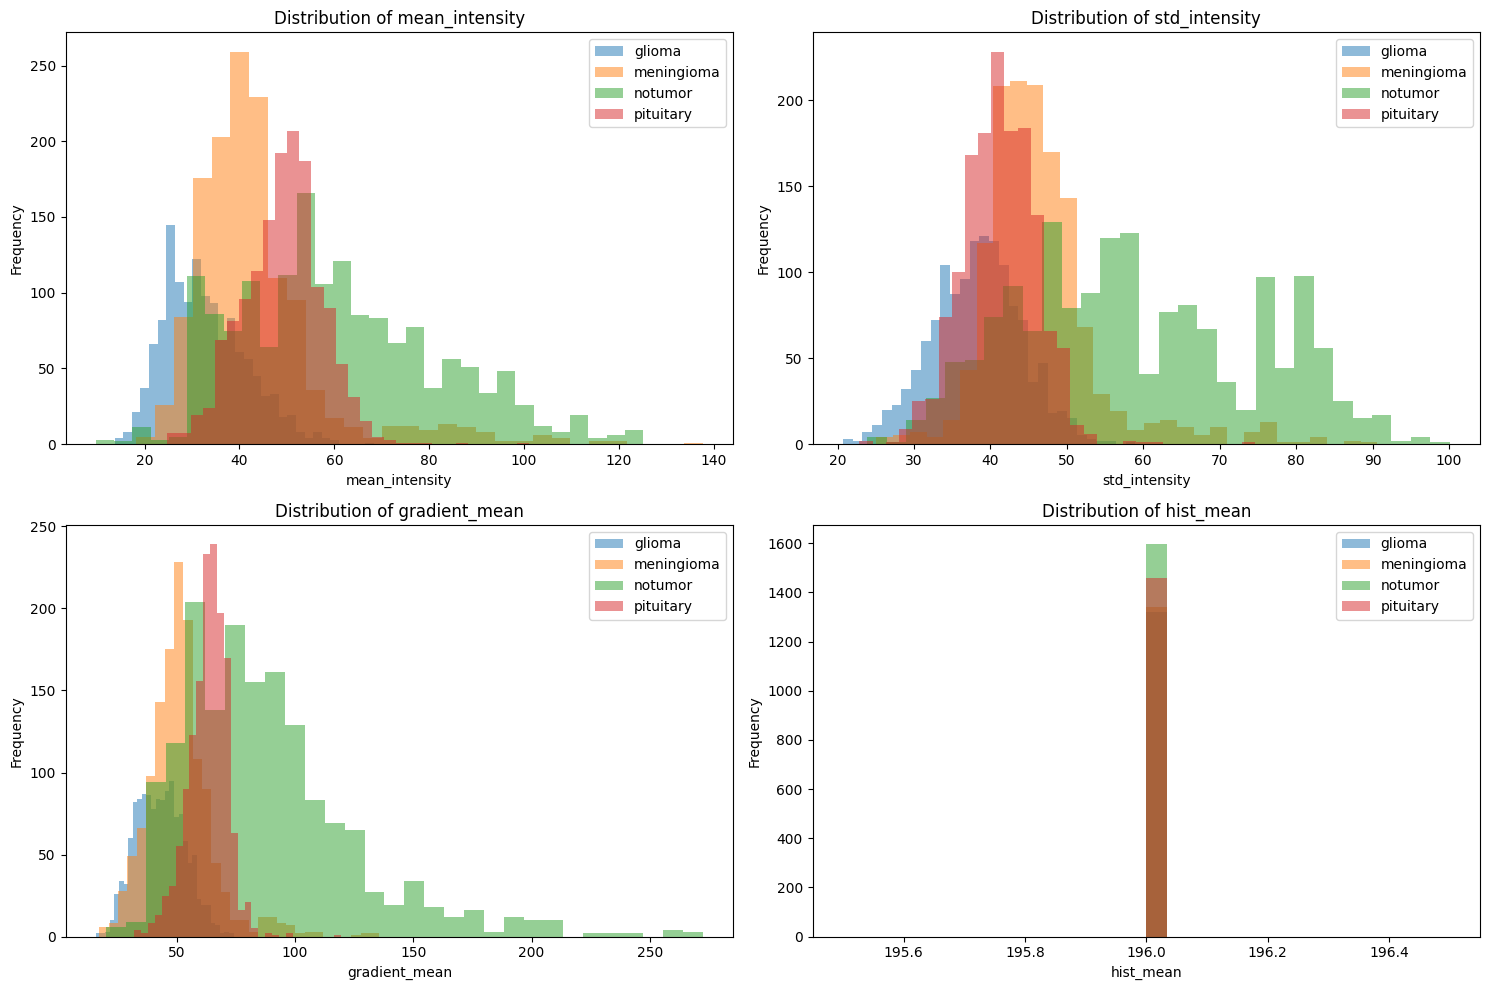

In [7]:
# Analyze extracted features
if 'class' in train_features_df.columns:
    print("Feature Statistics by Class:")
    print(train_features_df.groupby('class').describe())
    
    # Visualize feature distributions
    numeric_cols = train_features_df.select_dtypes(include=[np.number]).columns.tolist()
    if 'class' in numeric_cols:
        numeric_cols.remove('class')
    
    # Plot distributions for key features
    key_features = ['mean_intensity', 'std_intensity', 'gradient_mean', 'hist_mean']
    available_features = [f for f in key_features if f in numeric_cols]
    
    if available_features:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for idx, feature in enumerate(available_features[:4]):
            for class_name in class_names:
                class_data = train_features_df[train_features_df['class'] == class_name][feature]
                axes[idx].hist(class_data, alpha=0.5, label=class_name, bins=30)
            axes[idx].set_title(f'Distribution of {feature}')
            axes[idx].set_xlabel(feature)
            axes[idx].set_ylabel('Frequency')
            axes[idx].legend()
        
        plt.tight_layout()
        plt.show()


## 3. Model Creation - Transfer Learning with VGG16

We'll use transfer learning with a pre-trained VGG16 model as the base, then add custom layers for our classification task.


In [8]:
# Prepare data generators with augmentation
print("Preparing data generators...")
train_gen, val_gen = prepare_data_for_training(
    data_dir,
    img_size=(224, 224),
    batch_size=32,
    validation_split=0.2
)

print(f"\nTraining samples: {train_gen.samples}")
print(f"Validation samples: {val_gen.samples}")
print(f"Classes: {list(train_gen.class_indices.keys())}")
print(f"Number of classes: {len(train_gen.class_indices)}")


Preparing data generators...
Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.

Training samples: 4571
Validation samples: 1141
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of classes: 4


In [10]:
# Create and build the model
print("Creating model...")
classifier = BrainTumorClassifier(
    img_size=(224, 224),
    num_classes=len(class_names),
    base_model_name='VGG16'
)
classifier.class_names = class_names
classifier.build_model()

# Display model architecture
classifier.model.summary()


Creating model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 202s 3us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,772 (57.65 MB)

 Trainable params: 396,548 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## 4. Model Training with Optimization Techniques

We'll use several optimization techniques:
- **Early Stopping**: Prevent overfitting
- **Learning Rate Reduction**: Adaptive learning rate
- **Data Augmentation**: Increase dataset diversity
- **Dropout Regularization**: Prevent overfitting
- **Batch Normalization**: Stabilize training
- **Fine-tuning**: Unfreeze and retrain top layers


In [ ]:
# Create models directory
os.makedirs('../models', exist_ok=True)

# Train the model
print("Starting model training...")
print("=" * 50)

history = classifier.train(
    train_gen,
    val_gen,
    epochs=10,  # Initial training epochs
    fine_tune_epochs=5  # Fine-tuning epochs
)

print("\nTraining completed!")


Starting model training...
Phase 1: Training with frozen base model...
Epoch 1/10
 20/143 ━━━━━━━━━━━━━━━━━━━━ 15:26 8s/step - accuracy: 0.3277 - loss: 1.6930 - precision: 0.3612 - recall: 0.2421

In [ ]:
# Plot training history
classifier.plot_training_history('./models/training_history.png')
print("Training history plots saved.")

## 5. Model Evaluation with Multiple Metrics

Evaluate the model using comprehensive metrics:
- Accuracy
- Precision
- Recall
- F1-Score
- Confusion Matrix
- Per-class metrics

In [ ]:
# Evaluate on validation set
print("Evaluating model on validation set...")
results = classifier.evaluate(val_gen)

print("\n" + "=" * 50)
print("EVALUATION RESULTS")
print("=" * 50)
print(f"\nOverall Accuracy: {results['accuracy']:.4f}")
print(f"Weighted Precision: {results['precision']:.4f}")
print(f"Weighted Recall: {results['recall']:.4f}")
print(f"Weighted F1-Score: {results['f1_score']:.4f}")

print("\n" + "-" * 50)
print("Per-Class Metrics:")
print("-" * 50)
for class_name in results['class_names']:
    if class_name in results['classification_report']:
        metrics = results['classification_report'][class_name]
        print(f"\n{class_name.upper()}:")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1-Score: {metrics['f1-score']:.4f}")
        print(f"  Support: {metrics['support']}")

In [ ]:
# Plot confusion matrix
classifier.plot_confusion_matrix(
    results['confusion_matrix'],
    results['class_names'],
    './models/confusion_matrix.png'
)
print("Confusion matrix saved.")

# Display confusion matrix in notebook
plt.figure(figsize=(10, 8))
sns.heatmap(
    results['confusion_matrix'],
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=results['class_names'],
    yticklabels=results['class_names']
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [ ]:
# Detailed classification report
print("\n" + "=" * 50)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(
    val_gen.classes,
    np.argmax(classifier.model.predict(val_gen), axis=1),
    target_names=results['class_names']
))

## 6. Model Testing on Test Set

Evaluate the model on the test set to get final performance metrics.

In [ ]:
# Prepare test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print(f"Test samples: {test_gen.samples}")
print(f"Test classes: {list(test_gen.class_indices.keys())}")

In [ ]:
# Evaluate on test set
print("Evaluating model on test set...")
test_results = classifier.evaluate(test_gen)

print("\n" + "=" * 50)
print("TEST SET EVALUATION RESULTS")
print("=" * 50)
print(f"\nTest Accuracy: {test_results['accuracy']:.4f}")
print(f"Test Precision: {test_results['precision']:.4f}")
print(f"Test Recall: {test_results['recall']:.4f}")
print(f"Test F1-Score: {test_results['f1_score']:.4f}")

# Plot test confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    test_results['confusion_matrix'],
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=test_results['class_names'],
    yticklabels=test_results['class_names']
)
plt.title('Test Set Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 7. Model Prediction Functions

Test the model with individual predictions.

In [ ]:
# Import prediction module
from prediction import BrainTumorPredictor

# Load predictor
predictor = BrainTumorPredictor('./models/brain_tumor_model.h5')

print("Predictor loaded successfully!")
print(f"Model classes: {predictor.class_names}")

In [ ]:
# Test prediction on a sample image
sample_class = class_names[0]
sample_path = os.path.join(test_dir, sample_class)
sample_images = [f for f in os.listdir(sample_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

if sample_images:
    test_image_path = os.path.join(sample_path, sample_images[0])
    
    # Make prediction
    result = predictor.predict(test_image_path, return_probabilities=True)
    
    # Display image and prediction
    img = cv2.imread(test_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].imshow(img)
    axes[0].set_title(f'Test Image\nTrue Class: {sample_class}')
    axes[0].axis('off')
    
    # Plot probabilities
    classes = list(result['probabilities'].keys())
    probs = list(result['probabilities'].values())
    colors = ['green' if c == result['predicted_class'] else 'gray' for c in classes]
    
    axes[1].barh(classes, probs, color=colors)
    axes[1].set_xlabel('Probability')
    axes[1].set_title(f'Prediction Results\nPredicted: {result["predicted_class"]} ({result["confidence"]*100:.2f}%)')
    axes[1].set_xlim([0, 1])
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nPrediction Results:")
    print(f"True Class: {sample_class}")
    print(f"Predicted Class: {result['predicted_class']}")
    print(f"Confidence: {result['confidence']*100:.2f}%")
    print(f"\nAll Probabilities:")
    for class_name, prob in result['probabilities'].items():
        print(f"  {class_name}: {prob*100:.2f}%")

In [ ]:
# Save the model
classifier.save_model('./models/brain_tumor_model.h5')
print("Model saved successfully!")

# Save class names
import pickle
with open('./models/class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)
print("Class names saved!")

## Summary

This notebook demonstrated a complete ML pipeline for brain tumor classification:

1. ✅ **Data Exploration**: Analyzed dataset structure and class distribution
2. ✅ **Feature Extraction**: Extracted image features and saved to CSV
3. ✅ **Model Creation**: Built transfer learning model with VGG16
4. ✅ **Optimization**: Applied early stopping, learning rate reduction, data augmentation, dropout, and batch normalization
5. ✅ **Training**: Trained model with fine-tuning
6. ✅ **Evaluation**: Comprehensive evaluation with Accuracy, Precision, Recall, F1-Score, and Confusion Matrix
7. ✅ **Testing**: Evaluated on test set
8. ✅ **Prediction**: Tested prediction functionality

The model is now ready for deployment!
